# Preparing training data

In [2]:
# -- import packages -- 
from pathlib import Path
import numpy as np
import xgboost as xgb
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
training_data_file_name = 'all_record_2.json'
training_data_file_path = Path().absolute().parent / 'training_data' / training_data_file_name

with open(training_data_file_path, 'r', encoding='utf-8') as f:
    training_data: dict = json.load(f)

# keys = [ int(key) for key in training_data.keys()]
# values = list(training_data.values())
X, y = (np.array(training_data.get('request_number')).reshape(-1, 1), np.array(training_data.get('real_process_time')))

In [4]:
# training_data_file_name = 'data.json'
# training_data_file_path = Path().absolute().parent / 'training_data' / training_data_file_name

# with open(training_data_file_path, 'r', encoding='utf-8') as f:
#     training_data = json.load(f)

# # X, y = np.array(training_data.get('request_number')).reshape(-1, 1), np.array([training_data.get('user_cpu_time')[i] + training_data.get('system_cpu_time')[i] for i in range(len(training_data.get('user_cpu_time')))])
# X, y = (np.array(training_data.get('request_number'))).reshape(-1, 1), np.array(training_data.get('real_processing_time'))

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=43
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=43
)

# Xgboost

In [5]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Create XGBoost regression model
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=50,   # 基础学习器（树）的数量
    max_depth=3,        # 树的最大深度
    colsample_bytree=0.8,   # 随机选择特征的比例
    random_state=12,     # 保持结果可复现
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mea = mean_absolute_error(y_test, y_pred)
test_mea = np.mean(y_test)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mea}")
print(f"Mean Test Data: {test_mea}")


print(f"    real    |    pred   \n")
for i in range(len(y_test)):
    print(f"    {y_test[i]}     |     {y_pred[i]}      ")

Mean Squared Error: 0.0030836543316512294
Mean Absolute Error: 0.04298367342141839
Mean Test Data: 5.341395508691755
    real    |    pred   

    0.43134570121765137     |     0.4241856038570404      
    1.9179904460906982     |     1.9728550910949707      
    1.132716178894043     |     1.1133067607879639      
    6.445475339889526     |     6.487239837646484      
    3.508301019668579     |     3.4451334476470947      
    2.2327992916107178     |     2.252152919769287      
    2.1013810634613037     |     2.0276732444763184      
    1.5960402488708496     |     1.651637315750122      
    1.9664056301116943     |     1.9728550910949707      
    11.88526177406311     |     11.834894180297852      
    1.119751214981079     |     1.1133067607879639      
    12.087822437286377     |     11.937931060791016      
    0.08649730682373047     |     0.07957551628351212      
    5.956128358840942     |     5.922213077545166      
    11.587042570114136     |     11.516469955444336 

# Efficent Table

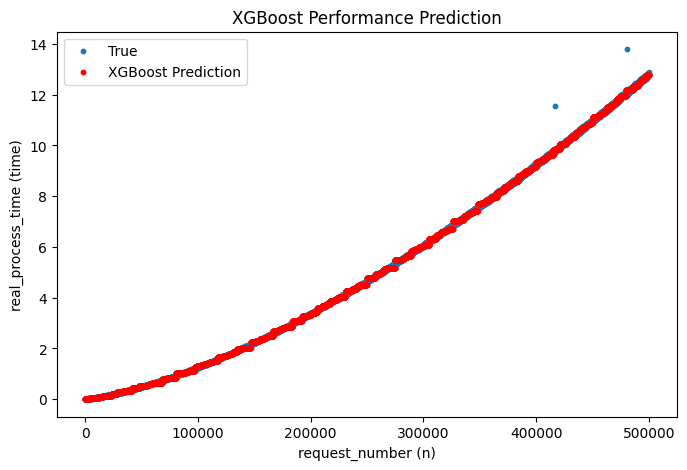

In [6]:
import matplotlib.pyplot as plt
y_pred_train = model.predict(X_train)

plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, s=10, label='True')
plt.scatter(X_train, y_pred_train, s=10, color='red', label='XGBoost Prediction')
plt.xlabel("request_number (n)")
plt.ylabel("real_process_time (time)")
plt.title("XGBoost Performance Prediction")
plt.legend()
plt.show()

# SHAP

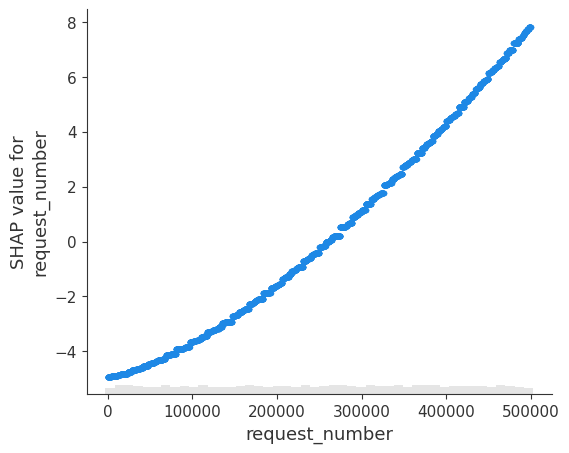

In [10]:
import pandas as pd
import shap
# 把你已有的 X_train 包装成 DataFrame
X_train_df = pd.DataFrame(X_train, columns=["request_number"])

# 建立 explainer
explainer = shap.Explainer(model, X_train_df)

# 得到 shap_values
shap_values = explainer(X_train_df)

# 画图：单特征直接 scatter（注意是 shap_values[:, 0]）
shap.plots.scatter(shap_values[:, 0])

# Save model

In [16]:
# model.save_model(Path() / 'modelsfile' / 'xgboost_newest_model_4.json')